In [10]:
import pandas as pd

In [11]:
# Read the CSV as a single column
df = pd.read_csv("scheduling_results_4_classes_cleaned_18-02-2025.csv", header=None)

# Split into multiple columns using the semicolon as a delimiter
df = df[0].str.split(';', expand=True)

In [12]:
# Assign proper column names
df.columns = ['instance', 'jobs', 'machines', 'strategy', 'tw', 'compression', 
              'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent', 'opt_class']

# Verify the DataFrame
print(df.head())

  instance jobs machines strategy tw compression overlapping  \
0     TA51   50       15    EST-M  2         Yes          No   
1     TA52   50       15    EST-M  2         Yes          No   
2     TA53   50       15    EST-M  2         Yes          No   
3     TA54   50       15    EST-M  2         Yes          No   
4     TA55   50       15    EST-M  2         Yes          No   

  #op_tw_with_overlap #op_tw #op_only_overlap makespan gap_to_opt_percent  \
0                 375    375                0     3070                 11   
1                 375    375                0     3128                 13   
2                 375    375                0     2956                  9   
3                 375    375                0     3039                  7   
4                 375    375                0     2998                 12   

  opt_class  
0         1  
1         1  
2         1  
3         1  
4         1  


In [13]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [14]:
# Convert numeric columns to appropriate types
numeric_cols = ['jobs', 'machines', 'tw', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Encode categorical variables (e.g., 'strategy', 'compression', 'overlapping')
label_encoder = LabelEncoder()
categorical_cols = ['strategy', 'compression', 'overlapping', 'opt_class']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])


# Define the features (X) and the target variable (y)
x = df[['jobs', 'machines', 'strategy', 'tw', 'compression', 'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap']]
y = df['gap_to_opt_percent']  # Target variable for regression

In [15]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
# Train the Regression Tree
reg_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=None, random_state=42)

# extract the set of cost complexity parameter alphas
ccp_alphas = reg_tree.cost_complexity_pruning_path(x_train,y_train)['ccp_alphas']

# view the complete list of effective alphas
ccp_alphas.tolist()

# setup parameter space
parameters = {'ccp_alpha':ccp_alphas.tolist()}

# create an instance of the grid search object
gsearch = GridSearchCV(reg_tree, parameters, cv=10)

# step 3: conduct grid search over the parameter space
gsearch.fit(x_train,y_train)

# show best parameter configuration found for classifier
gsearch.best_params_

# extract best classifier
clf = gsearch.best_estimator_

# produce classification report
y_pred = clf.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100

print("Mean Squared Error:", mse)
print("R2 Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

Mean Squared Error: 238.1466086994974
R2 Score: 0.9218745743948354
Mean Absolute Percentage Error (MAPE): inf %


C:\Users\Mohammed El-Kholany\AppData\Local\Temp\ipykernel_28808\3599130360.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')


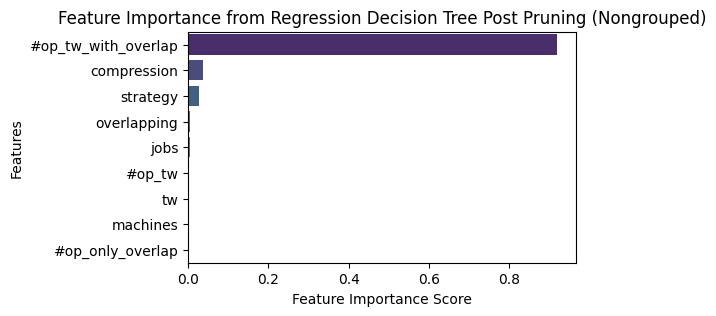

In [17]:
# Feature Importance Analysis
feature_importances = clf.feature_importances_
features = x.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(5, 3))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Regression Decision Tree Post Pruning (Nongrouped)")
plt.show()